# Part 2 

Le but de cette première partie est de faire un LSTM sans associée une review à une note pour voir comment le modèle se comporte

In [7]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

nltk.download('stopwords')

# Load dataset
reviews_df = pd.read_csv('Restaurant reviews.csv')
reviews_df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [8]:
#On se débarasse des colonnes inutiles 

reviews_df = reviews_df.drop(["Reviewer", "Metadata", "Pictures" ,"7514"], axis=1)
print(reviews_df.shape)

print(reviews_df.info())

(10000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Review      9955 non-null   object
 2   Rating      9962 non-null   object
 3   Time        9962 non-null   object
dtypes: object(4)
memory usage: 312.6+ KB
None


In [9]:
reviews_df['Rating'] = pd.to_numeric(reviews_df['Rating'], errors='coerce')

# On supprime les lignes vides 

reviews_df = reviews_df.dropna(subset=['Rating'])
reviews_df = reviews_df.dropna(subset=['Review'])

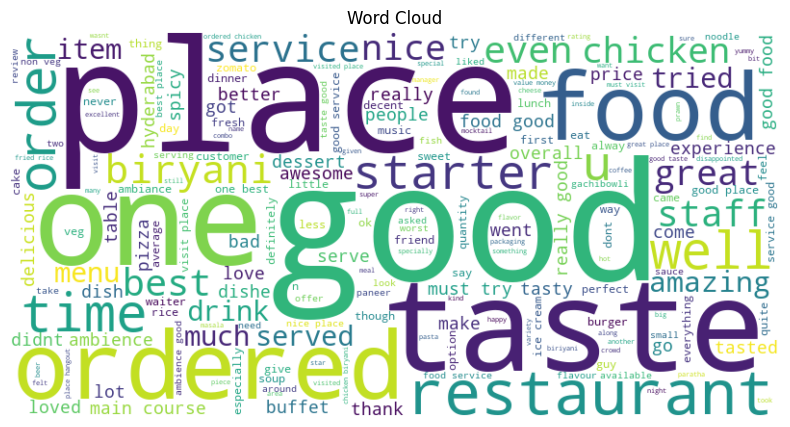

In [10]:
# On nettoie les reviews avec stopwords, tout en minuscule etc...
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

reviews_df['Processed_Review'] = reviews_df['Review'].astype(str).apply(preprocess_text)
reviews_df.head()

all_words = ' '.join(reviews_df['Processed_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()



In [11]:
ratings = reviews_df['Rating'].astype(int).tolist()
glove_file = 'glove.6B.100d.txt'  

# Charger GloVe dans un dictionnaire Python
glove_model = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector
print("GloVe model loaded successfully.")


GloVe model loaded successfully.


In [12]:
# Tokenize les reviews
texts = reviews_df['Processed_Review'].tolist()
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

np.random.seed(42)
y = np.random.randint(0, 2, size=len(X))

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Paramètres de configuration
vocab_size = 5000  # Limite du vocabulaire à 5000 mots
embedding_dim = 100  # Dimension des embeddings correspondant à GloVe
max_length = 100  # Longueur maximale des séquences
padding_type = 'post'
trunc_type = 'post'

# Initialisation du tokenizer avec un token pour les mots inconnus
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews_df['Processed_Review'])

# Conversion des textes en séquences et application du padding
sequences = tokenizer.texts_to_sequences(reviews_df['Processed_Review'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Préparation des labels (en supposant que vous avez déjà nettoyé les notes pour être 0 (négatif) ou 1 (positif))
# Supposons que les ratings soient sur une échelle de 1 à 5
# On peut définir une règle simple : rating >= 3 -> positif (1), rating < 3 -> négatif (0)
reviews_df['Sentiment'] = reviews_df['Rating'].apply(lambda x: 1 if x >= 3 else 0)
y = reviews_df['Sentiment'].values
reviews_df.head()

# Chargement de la matrice d'embedding pré-entraînée GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        embedding_vector = glove_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)


## Building and Training the LSTM Model
We'll build a Bidirectional LSTM model to capture sequential dependencies in the review texts and train it on our processed and tokenized data.

In [14]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.7755 - loss: 0.4901 - val_accuracy: 0.9146 - val_loss: 0.2311
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.9322 - loss: 0.1792 - val_accuracy: 0.9153 - val_loss: 0.2332
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.9623 - loss: 0.1075 - val_accuracy: 0.9052 - val_loss: 0.2615
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - accuracy: 0.9693 - loss: 0.0876 - val_accuracy: 0.9077 - val_loss: 0.3085
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9804 - loss: 0.0609 - val_accuracy: 0.9021 - val_loss: 0.3568
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step - accuracy: 0.9805 - loss: 0.0548 - val_accuracy: 0.8964 - val_loss: 0.4220
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.9800 - loss: 0.0588 - val_accuracy: 0.8977 - val_loss: 0.4224
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.9853 - loss: 0.0444 - 

## Model Evaluation
We'll evaluate our model on the test set to determine its accuracy and analyze its performance with a classification report and confusion matrix.

In [15]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"])
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Accuracy: 0.8749372174786539

Classification Report:
               precision    recall  f1-score   support

    Negative       0.74      0.79      0.76       501
    Positive       0.93      0.90      0.92      1490

    accuracy                           0.87      1991
   macro avg       0.83      0.85      0.84      1991
weighted avg       0.88      0.87      0.88      1991


Confusion Matrix:
 [[ 394  107]
 [ 142 1348]]


## Training and Validation Accuracy and Loss
Let's plot the training and validation accuracy and loss to visualize how well the model trained over epochs.

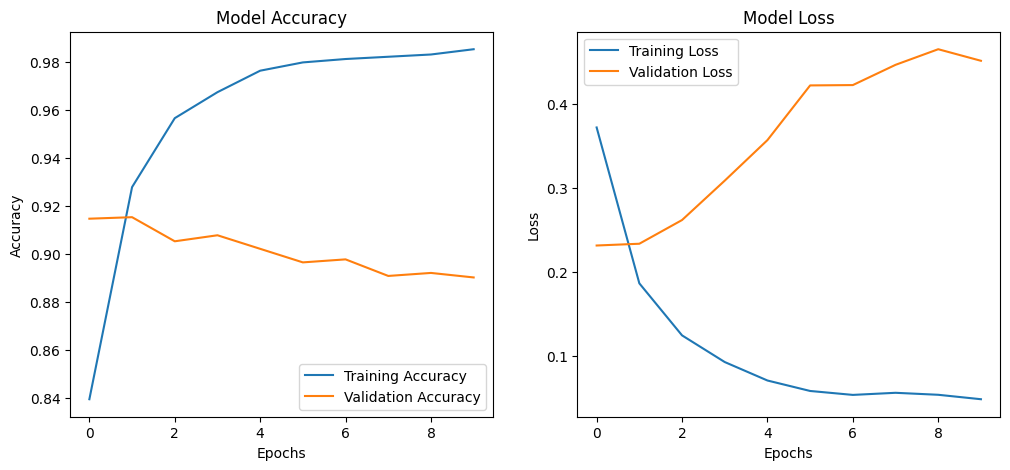

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


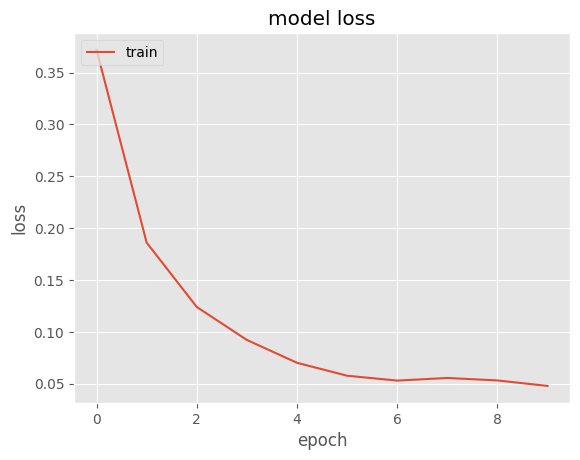

In [17]:
plt.style.use('ggplot')
%matplotlib inline

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()